# CelebA 32x32 Model Training Notebook

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
from IPython import display
import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings("ignore")

In [2]:
#limit memory usage on gpus
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Set Distribution Strategy
### Note: Below Cell Defines Distribution Strategy
### Run the first cell for distributed training, or the 2nd cell for single GPU training

In [3]:
#set distribution strategy
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [ ]:
## set this strategy for single GPU
strategy = tf.distribute.get_strategy()

### Tensorflow function to decode image and crop, resize and scale to tanh range for training

In [4]:
#augmentation function for tensorflow dataset
@tf.function
def prepare_image_celeb(img, dim=32):   
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.central_crop(img, 0.60)
    img = tf.image.resize(img,size=[dim,dim])
    img = (tf.cast(img, tf.float32) - 127.5) / 127.5
    return img

In [5]:
#Import DCGAN class
from SourceFiles.ModelSourceFiles.DCGAN import *

#Import Utilities
from SourceFiles.Utilities.Utils import *

# Create CelebA Dataset

In [6]:
#create 
BUFFER_SIZE = 10000
BATCH_SIZE = 512 * strategy.num_replicas_in_sync
img_files = tf.io.gfile.glob('celeb/img_align_celeba/*.jpg')
celeb_train = tf.data.Dataset.from_tensor_slices(img_files)
celeb_train = celeb_train.map(prepare_image_celeb, num_parallel_calls=tf.data.experimental.AUTOTUNE)
celeb_train = celeb_train.shuffle(BUFFER_SIZE)
celeb_train = celeb_train.batch(BATCH_SIZE)
celeb_train = celeb_train.prefetch(tf.data.experimental.AUTOTUNE)
celeb_train = celeb_train.cache()

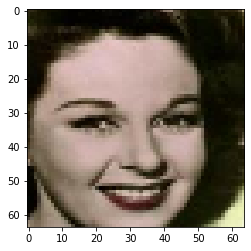

In [7]:
img = celeb_train.take(1)
for each in img:
    each = each.numpy()
    plt.imshow((each[1, :, :, :] * 127.5 + 127.5).astype(np.uint8))
plt.show()

# Train and Evaluate A DCGAN Model

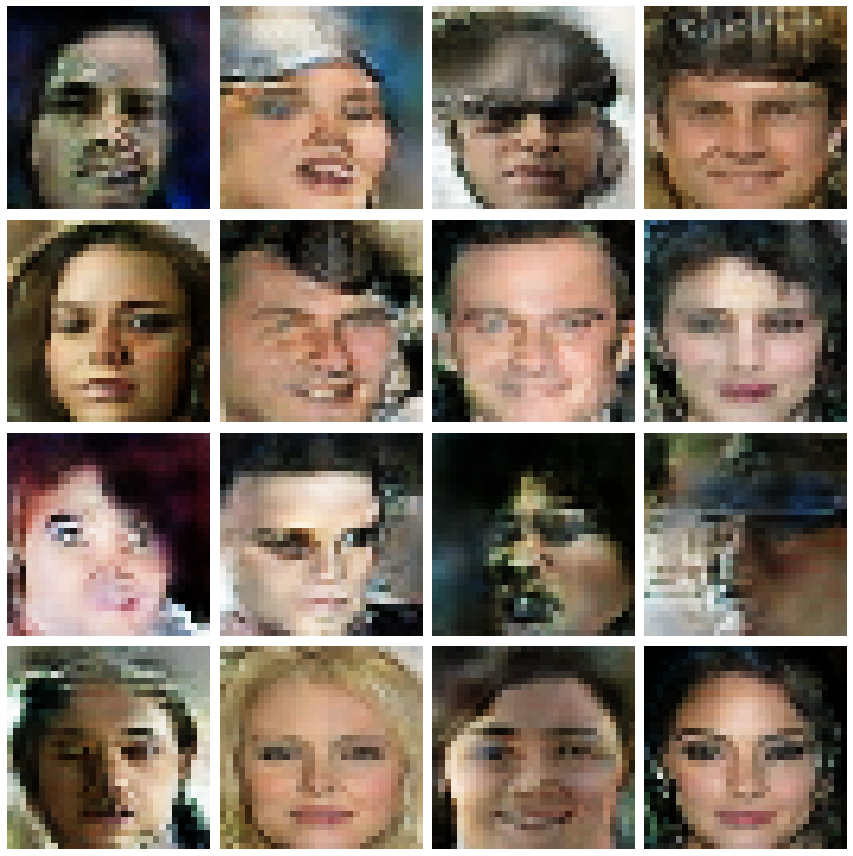

205/205 [==============================] - 139s 678ms/step - Generator_Loss: 0.4684 - Discriminator_Real_Loss: 0.3347 - Discriminator_Generator_Loss: 0.3336 - Average_Discriminator_Loss: 0.3342 - Discriminator_Generator_Accuracy: 0.6142 - Discriminator_Real_Accuracy: 0.5460
CPU times: user 20min 30s, sys: 7min 38s, total: 28min 8s
Wall time: 2h 20min 15s


In [8]:
%%time
with strategy.scope():
    distribute_training = True
    
    #define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    
    #dictionary to define generator architecture 
    gen_dict = {'num_latent':100,
             "filter_num":[512,256,128],
             "filter_size":[8,5,5], 
             "strides":[2,2,2],
             'dense':(4,4,1024), 
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    #dictionary to define discriminator architecture 
    disc_dict = {"filter_num": [128, 256, 512],
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0.0,
             'random_noise':False}

    distributed_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     label_smoothing=0.1,
                                                     reduction=tf.keras.losses.Reduction.NONE)
    
    single_gpu_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     label_smoothing=0.1)
    
    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=512, model_name='Celeb32x32_no_drop',
                  distribute=distribute_training)
    
    if distribute_training == True:
        model.compile(generator_optimizer, discriminator_optimizer, distributed_loss)
    else:
        model.compile(generator_optimizer, discriminator_optimizer, single_gpu_loss)
        
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    history_1 = model.fit(x=celeb_train, epochs=60, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    

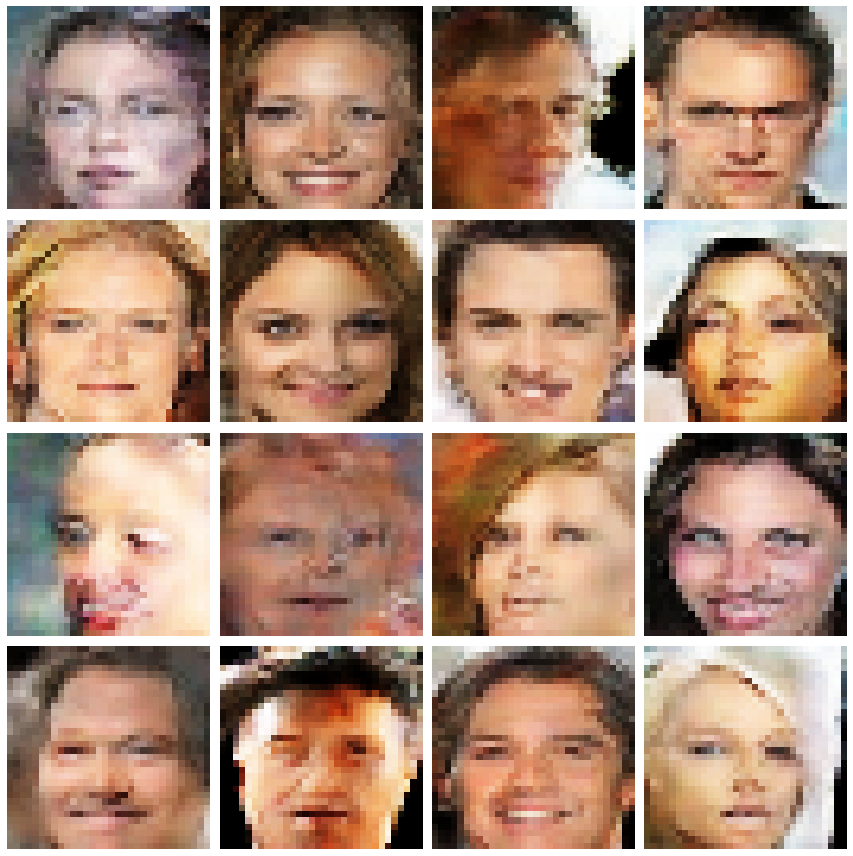

205/205 [==============================] - 140s 682ms/step - Generator_Loss: 0.4803 - Discriminator_Real_Loss: 0.3323 - Discriminator_Generator_Loss: 0.3313 - Average_Discriminator_Loss: 0.3318 - Discriminator_Generator_Accuracy: 0.6259 - Discriminator_Real_Accuracy: 0.5518
CPU times: user 18min 43s, sys: 7min 1s, total: 25min 45s
Wall time: 2h 21min 10s


In [9]:
%%time
with strategy.scope():
    distribute_training = True
    
    #define optimizers
    generator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5) #learning rate by x10
    discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1 = 0.5)
    
    #dictionary to define generator architecture  
    gen_dict = {'num_latent':100,
             "filter_num":[512,256,128],
             "filter_size":[8,5,5], 
             "strides":[2,2,2],
             'dense':(4,4,1024), 
             'activation':'relu', 
             'out_channels':3,
             'latent_distribution':'normal'}
    
    disc_dict = {"filter_num": [128, 256, 512],
             "filter_size": [5, 5, 5],
             'activation': 'leakyrelu',
             'out_channels': 3,
             'dropout':0.4,
             'random_noise':False}

    distributed_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     label_smoothing=0.1,
                                                     reduction=tf.keras.losses.Reduction.NONE)
    
    single_gpu_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                                     label_smoothing=0.1)
    
    model = DCGAN(gen_dict=gen_dict, disc_dict=disc_dict, batch_size=512, model_name='Celeb32x32_0.4_drop',
                  distribute=distribute_training)
    
    if distribute_training == True:
        model.compile(generator_optimizer, discriminator_optimizer, distributed_loss)
    else:
        model.compile(generator_optimizer, discriminator_optimizer, single_gpu_loss)
        
    save_callback = SaveModelAndCreateImages()
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=model.log_path)
    
    history_2 = model.fit(x=celeb_train, epochs=60, callbacks=[save_callback,tensorboard_callback],shuffle=True)
    